# 呼吸范围实验数据处理
这段是生成最终合成两个向量的代码，此时只需要处理数据，不需要这个。


In [152]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# import csv
# import math
# import json
# from collections import defaultdict, OrderedDict
# from pathlib import Path

# def safe_float(x):
#     try:
#         return float(x)
#     except Exception:
#         return float('nan')

# def combine_iq(il, ql, ir, qr):
#     # 对应 calculate_vec_cmac_f 的单点版
#     I = ir * il - qr * ql
#     Q = ir * ql + il * qr
#     return I, Q

# def parse_and_combine(csv_path: str):
#     """
#     读取 iq_flat.csv，按 (index, ap_index) → ch 聚合，计算合成 IQ 及幅值/相位。
#     返回一个 dict：key=(index, ap_index)，value=结构化结果。
#     """
#     results = {}
#     # 暂存每个 (index, ap_index) 的公共 meta（以第一条为准）
#     meta_map = {}
#     # 暂存每个 (index, ap_index) 下各通道的原始 il/ql/ir/qr
#     chans_map = defaultdict(dict)  # {(index, ap_index): {ch: {il,ql,ir,qr}}}

#     with open(csv_path, "r", encoding="utf-8") as f:
#         reader = csv.DictReader(f)
#         for row in reader:
#             try:
#                 index = int(row["index"])
#                 ap_index = int(row["ap_index"])
#                 key = (index, ap_index)

#                 # 记录 meta（只填一次）
#                 if key not in meta_map:
#                     meta_map[key] = {
#                         "index": index,
#                         "timestamp_ms": int(float(row.get("timestamp_ms", "nan"))),
#                         "role": row.get("role"),
#                         "ap_index": ap_index,
#                         "tone_quality": row.get("tone_quality"),
#                         "distance_ifft": safe_float(row.get("distance_ifft", "nan")),
#                         "distance_phase_slope": safe_float(row.get("distance_phase_slope", "nan")),
#                         "distance_rtt": safe_float(row.get("distance_rtt", "nan")),
#                         "distance_best": safe_float(row.get("distance_best", "nan")),
#                     }

#                 ch = int(row["ch"])
#                 il = safe_float(row["il"])
#                 ql = safe_float(row["ql"])
#                 ir = safe_float(row["ir"])
#                 qr = safe_float(row["qr"])

#                 chans_map[key][ch] = {"il": il, "ql": ql, "ir": ir, "qr": qr}
#             except Exception:
#                 # 忽略不合规行
#                 continue

#     # 计算合成 I/Q、幅值、相位
#     for key, ch_dict in chans_map.items():
#         # 保持通道有序
#         ordered_channels = OrderedDict(sorted(ch_dict.items(), key=lambda kv: kv[0]))
#         result_entry = {
#             "meta": meta_map.get(key, {}),
#             "channels": OrderedDict()
#         }
#         for ch, vals in ordered_channels.items():
#             il, ql, ir, qr = vals["il"], vals["ql"], vals["ir"], vals["qr"]
#             I, Q = combine_iq(il, ql, ir, qr)
#             mag = math.hypot(I, Q)  # sqrt(I^2 + Q^2)
#             phase = math.atan2(Q, I)  # 弧度

#             result_entry["channels"][ch] = {
#                 "il": il, "ql": ql, "ir": ir, "qr": qr,
#                 "I": I, "Q": Q,
#                 "mag": mag,
#                 "phase_rad": phase
#                 # 如需角度： "phase_deg": math.degrees(phase)
#             }
#         results[key] = result_entry

#     return results

# def save_combined_csv(results: dict, out_csv: str):
#     """
#     扁平化导出合成结果，便于直接画图或 pandas 使用。
#     列：index,timestamp_ms,role,ap_index,tone_quality,dist_*,ch,il,ql,ir,qr,I,Q,mag,phase_rad
#     """
#     header = [
#         "index","timestamp_ms","role","ap_index","tone_quality",
#         "distance_ifft","distance_phase_slope","distance_rtt","distance_best",
#         "ch","il","ql","ir","qr","I","Q","mag","phase_rad"
#     ]
#     with open(out_csv, "w", newline="", encoding="utf-8") as w:
#         writer = csv.writer(w)
#         writer.writerow(header)
#         for (index, ap_index), entry in sorted(results.items()):
#             meta = entry["meta"]
#             for ch, v in entry["channels"].items():
#                 writer.writerow([
#                     meta.get("index"), meta.get("timestamp_ms"), meta.get("role"),
#                     meta.get("ap_index"), meta.get("tone_quality"),
#                     meta.get("distance_ifft"), meta.get("distance_phase_slope"),
#                     meta.get("distance_rtt"), meta.get("distance_best"),
#                     ch, v["il"], v["ql"], v["ir"], v["qr"],
#                     v["I"], v["Q"], v["mag"], v["phase_rad"]
#                 ])

# def save_combined_json(results: dict, out_json: str):
#     """
#     将 results（以 (index, ap_index) 为键的 dict）转换为列表再保存 JSON。
#     每个元素包含 meta 和 channels，且顶层显式带 index, ap_index 字段。
#     """
#     serializable = []
#     for (index, ap_index), entry in sorted(results.items()):
#         serializable.append({
#             "index": index,
#             "ap_index": ap_index,
#             "meta": entry.get("meta", {}),
#             "channels": entry.get("channels", {})  # channels 是 OrderedDict[int -> dict]，可直接序列化
#         })
#     with open(out_json, "w", encoding="utf-8") as w:
#         json.dump(serializable, w, ensure_ascii=False, indent=2)

# if __name__ == "__main__":
#     # 使用示例
#     # UartAssist.bre.n5+l1_20250817_145410_iq_flat
#     in_csv = "UartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv"           # 你的输入 CSV 文件名
#     out_csv = "combined_iq" + in_csv + ".csv"      # 合成结果 CSV
#     out_json = "combined_iq"+ in_csv + ".json"    # 合成结果 JSON（结构化，便于调试/二次处理）

#     results = parse_and_combine(in_csv)
#     print(f"parsed (report, ap) groups: {len(results)}")

#     save_combined_csv(results, out_csv)
#     save_combined_json(results, out_json)
#     print(f"Saved: {out_csv}")
#     print(f"Saved: {out_json}")

In [193]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
read_csv = "combined_iqUartAssist.1mcable_20250816_182503_iq_flat.csv.csv"
# combined_iqUartAssist.1mcable_20250816_182503_iq_flat.csv
# combined_iqUartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv
# combined_iqUartAssist.bre.n5+l1_20250817_145410_iq_flat.csv.json,幅相关系用图
read_json = "combined_iquart_20250828_174505_iq_flat.csv.json"
# 读取并预处理
with open('./ble.bre/'+read_json, "r", encoding="utf-8") as f:
    data_to_parse = json.load(f)  # list of {index, ap_index, meta, channels}


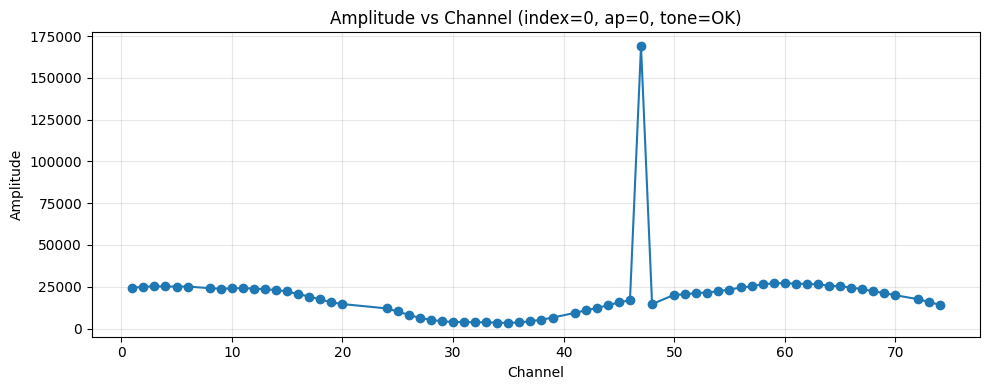

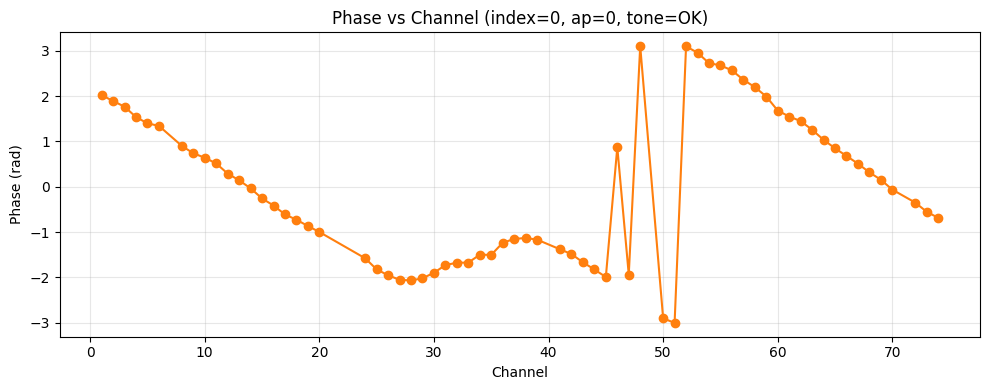

In [194]:

# 将 channels 的键由 str 转回 int，并按 ch 升序排列
for item in data_to_parse:
    item["channels"] = {int(k): v for k, v in item["channels"].items()}

# 选择要画的 report 和 AP
target_index = 0        # 想看的 report index
target_ap = 0           # 想看的 ap_index

entry = next(
    (it for it in data_to_parse if it["index"] == target_index and it["ap_index"] == target_ap),
    None
)
if entry is None:
    raise ValueError(f"找不到 index={target_index}, ap_index={target_ap} 的条目")

# 取出通道、有序排列
chs = sorted(entry["channels"].keys())
I = np.array([entry["channels"][ch]["I"] for ch in chs], dtype=float)
Q = np.array([entry["channels"][ch]["Q"] for ch in chs], dtype=float)
mag = np.array([entry["channels"][ch]["mag"] for ch in chs], dtype=float)
phase_rad = np.array([entry["channels"][ch]["phase_rad"] for ch in chs], dtype=float)
phase_deg = np.degrees(phase_rad)  # 若想用度数显示

# 去除0通道和NaN
is_nan = np.isnan(I) | np.isnan(Q) | np.isnan(mag) | np.isnan(phase_rad)

# 判全 0：mag==0 或 (I==0 且 Q==0)。加入阈值更稳健：
eps = 1e-12
is_zero = (np.abs(mag) <= eps) | ((np.abs(I) <= eps) & (np.abs(Q) <= eps))

mask = ~(is_nan | is_zero)

chs = np.array(chs)[mask].tolist()   # 保留后的通道索引
I = I[mask]
Q = Q[mask]
mag = mag[mask]
phase_rad = phase_rad[mask]
phase_deg = np.degrees(phase_rad)

# 幅值 vs 通道
plt.figure(figsize=(10, 4))
plt.plot(chs, mag, marker='o', lw=1.5)
plt.title(f"Amplitude vs Channel (index={entry['index']}, ap={entry['ap_index']}, tone={entry['meta'].get('tone_quality')})")
plt.xlabel("Channel")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./finebre.fig/Amplitude vs Channel.svg', dpi=300)
plt.savefig(f'./finebre.fig/Amplitude vs Channel.pdf', dpi=300) 
plt.show()

# 相位 vs 通道（以度为例，也可改用 phase_rad）
plt.figure(figsize=(10, 4))
plt.plot(chs, phase_rad, marker='o', lw=1.5, color='tab:orange')
plt.title(f"Phase vs Channel (index={entry['index']}, ap={entry['ap_index']}, tone={entry['meta'].get('tone_quality')})")
plt.xlabel("Channel")
plt.ylabel("Phase (rad)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./ble.bre/finebre.fig/Phase vs Channel.svg', dpi=300)
plt.savefig(f'./ble.bre/finebre.fig/Phase vs Channel.pdf', dpi=300) 
plt.show()

需要读取呼吸传感器的数据


In [195]:
# -*- coding: utf-8 -*-
"""
读取压电式呼吸传感器 txt，解析每行 7 个十六进制字节，取倒数第2与倒数第1字节组成 16 位无符号值，
生成等时序（50 Hz）的十进制波形数组，并可保存为 CSV/NPY。
提供与 BLE 波形对齐后计算 RMSE 与皮尔逊相关系数的工具函数。

使用要点：
- 示例行: "FF CC 05 9D A0 01 F7" -> 取 01(FS高位), F7(低位) -> 0x01F7 -> 503
- 文件中可能有杂散行（如只有 "CC"），会自动跳过
"""

from __future__ import annotations
import numpy as np
from typing import List, Tuple, Optional, Iterable
from pathlib import Path
import csv

def parse_hex_line_to_value(tokens: List[str]) -> Optional[int]:
    """
    输入：一行分割后的十六进制字符串列表（大小写均可），期望长度>=2
    逻辑：取倒数第二个与倒数第一个字节组成 16 位无符号数 val = (hi<<8)|lo
    若格式不符或解析失败，返回 None。
    """
    # 需要至少两个字节
    if len(tokens) < 2:
        return None
    try:
        # 取倒数两个字节
        hi_str = tokens[-2]
        lo_str = tokens[-1]
        # 过滤非 2 位、但也允许 1~2 位（例如 '1', 'F7'）
        hi = int(hi_str, 16)
        lo = int(lo_str, 16)
        if not (0 <= hi <= 0xFF and 0 <= lo <= 0xFF):
            return None
        val = (hi << 8) | lo
        return val
    except Exception:
        return None


def load_piezo_waveform_from_txt(
    txt_path: str | Path,
    sample_rate_hz: float = 50.0,
    strict_7_bytes: bool = False,
    to_uint16: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    读取压电传感器 txt 文件，返回时间轴 t 与波形 y。

    参数：
      - txt_path: 文本文件路径
      - sample_rate_hz: 采样率（默认 50 Hz），用于构造时间轴
      - strict_7_bytes: 若为 True，则仅当行中恰有 7 个 token 时才解析，否则跳过；
                        若为 False，则只要末尾两个 token 可解析为字节即取之。
      - to_uint16: True 时返回 y.dtype=uint16；False 则返回 float64

    返回：
      - t: shape (N,), 单位秒，从 0 开始，步长 1/fs
      - y: shape (N,), 波形值（uint16 或 float64）
    """
    txt_path = Path(txt_path)
    values: List[int] = []

    with txt_path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            # 用空白切分；允许行内有多余空格
            tokens = s.split()
            # 可选：严格 7 字节检查
            if strict_7_bytes and len(tokens) != 7:
                continue
            # 解析为末尾两个字节
            val = parse_hex_line_to_value(tokens)
            if val is None:
                continue
            values.append(val)

    if len(values) == 0:
        # 空结果
        return np.array([], dtype=float), np.array([], dtype=np.uint16 if to_uint16 else float)

    y = np.array(values, dtype=np.uint16)
    if not to_uint16:
        y = y.astype(float)

    fs = float(sample_rate_hz)
    dt = 1.0 / fs if fs > 0 else 0.0
    t = np.arange(len(y), dtype=float) * dt
    return t, y


def save_waveform_csv(
    out_csv: str | Path,
    t: np.ndarray,
    y: np.ndarray,
    header: bool = True,
):
    """
    保存为 CSV，两列：time_s, value
    """
    out_csv = Path(out_csv)
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    with out_csv.open("w", newline="", encoding="utf-8") as w:
        writer = csv.writer(w)
        if header:
            writer.writerow(["time_s", "value"])
        for ti, yi in zip(t, y):
            writer.writerow([f"{ti:.9f}", int(yi) if np.issubdtype(y.dtype, np.integer) else float(yi)])


def save_waveform_npy(out_npy: str | Path, y: np.ndarray):
    """
    保存为 NPY（仅波形数组），更适合后续快速加载
    """
    out_npy = Path(out_npy)
    out_npy.parent.mkdir(parents=True, exist_ok=True)
    np.save(out_npy, y)


# ============ 与 BLE 波形比较：RMSE 与皮尔逊相关系数 ============

def interpolate_to_common_time(
    t_ref: np.ndarray,
    y_ref: np.ndarray,
    t_other: np.ndarray,
    y_other: np.ndarray,
    t_start: Optional[float] = None,
    t_end: Optional[float] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    将两路波形裁剪到共同时间窗 [t_start, t_end]，并把 other 线性插值到 ref 的时间轴上。
    默认 t_start/end 取两序列交集区间。

    返回：
      - t: 公共时间轴（即 t_ref 在交集窗内的样本）
      - y_ref_win: y_ref 在该时间窗内
      - y_other_interp: y_other 插值到 t 上
    """
    if t_start is None:
        t_start = max(float(t_ref[0]), float(t_other[0]))
    if t_end is None:
        t_end = min(float(t_ref[-1]), float(t_other[-1]))
    if t_end <= t_start:
        return np.array([]), np.array([]), np.array([])

    # 选择 ref 上处于交集窗的样本
    mask = (t_ref >= t_start) & (t_ref <= t_end)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    t = t_ref[mask]
    y_ref_win = y_ref[mask]

    # 线性插值 other 到 t
    # 需要确保 t 在 t_other 的范围内
    # 进一步裁剪 t 到 [t_other.min, t_other.max]
    tmin, tmax = float(t_other[0]), float(t_other[-1])
    mask2 = (t >= tmin) & (t <= tmax)
    t = t[mask2]
    y_ref_win = y_ref_win[mask2]
    if t.size == 0:
        return np.array([]), np.array([]), np.array([])

    y_other_interp = np.interp(t, t_other, y_other)
    return t, y_ref_win, y_other_interp


def rmse(a: np.ndarray, b: np.ndarray) -> float:
    """
    均方根误差
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.size != b.size:
        return float("nan")
    return float(np.sqrt(np.mean((a - b) ** 2)))


def pearson_corr(a: np.ndarray, b: np.ndarray) -> float:
    """
    皮尔逊相关系数（-1..1）
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0 or a.size != b.size:
        return float("nan")
    # 去均值，避免常数序列导致除零
    a0 = a - np.mean(a)
    b0 = b - np.mean(b)
    denom = np.sqrt(np.sum(a0**2) * np.sum(b0**2))
    if denom == 0:
        return float("nan")
    return float(np.sum(a0 * b0) / denom)


# =========================
# 示例用法
# =========================
if __name__ == "__main__":
    # 1) 读取压电 txt
    txt_file = "piezo_50hz_sample.txt"
    txt_file = "./ble.bre/Data/"+"20250828170645_322.txt"
    t_piezo, y_piezo = load_piezo_waveform_from_txt(
        txt_file,
        sample_rate_hz=50.0,    # 你的传感器采样率
        strict_7_bytes=False,   # 允许非 7 token 行，只要末尾两字节能解析
        to_uint16=False,        # 后续计算方便，直接用 float
    )
    print(f"Loaded piezo: {len(y_piezo)} samples, duration ~ {t_piezo[-1] if t_piezo.size else 0:.3f}s")

    # 2) 可选：保存
    save_waveform_csv("./ble.bre/Data/"+txt_file+"piezo_waveform.csv", t_piezo, y_piezo)
    save_waveform_npy("./ble.bre/Data/"+txt_file+"piezo_waveform.npy", y_piezo)

    # 3) 若已从 BLE 构造出波形（时间轴 t_ble, 波形 y_ble）
    # 下面演示如何比较（将 piezo 插值到 BLE 时间轴，或反之）
    # 示例：假设 t_ble, y_ble 已经存在（这里用占位）
    # t_ble = np.linspace(0, 10, 200)  # 例如 20 Hz, 10 秒
    # y_ble = np.sin(2*np.pi*0.25*t_ble) * 200 + 400  # 示意

    # 将 piezo 插值到 BLE 时间轴并比较
    # t_common, y_ble_win, y_piezo_interp = interpolate_to_common_time(t_ble, y_ble, t_piezo, y_piezo)
    # r = pearson_corr(y_ble_win, y_piezo_interp)
    # e = rmse(y_ble_win, y_piezo_interp)
    # print(f"RMSE: {e:.3f}, Pearson r: {r:.4f}")

Loaded piezo: 2265 samples, duration ~ 45.280s


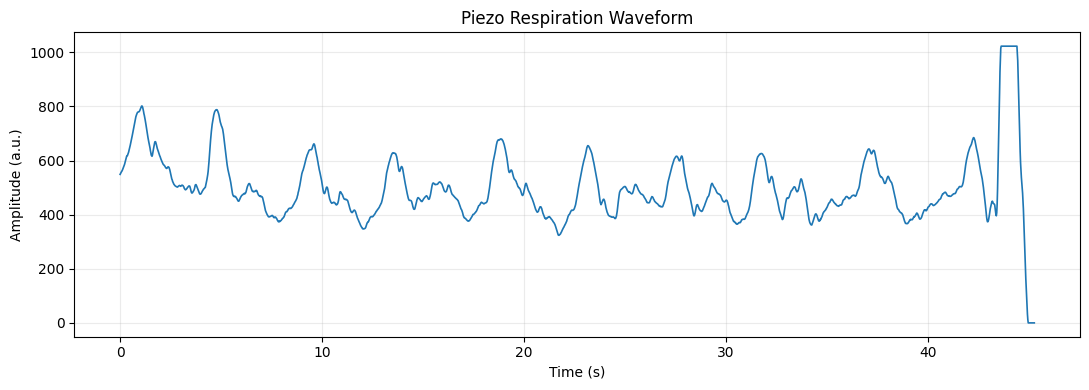

In [196]:
def plot_piezo_waveform(
    txt_file: str | Path,
    sample_rate_hz: float = 50.0,
    title: Optional[str] = None,
    detrend: bool = False,
    normalize: bool = False,
    save_dir: Optional[str | Path] = None,
    save_basename: Optional[str] = None,
    figsize: Tuple[float, float] = (11, 4),
    color: str = "tab:blue",
    linewidth: float = 1.2,
):
    """
    绘制压电式呼吸传感器波形
    - detrend: 去线性趋势（简单差分或线性去趋势）
    - normalize: 归一化到 [0,1]（便于和其他波形叠加比较）
    - save_dir/save_basename: 指定则保存为 PNG/SVG/PDF
    """
    t, y = load_piezo_waveform_from_txt(txt_file, sample_rate_hz=sample_rate_hz, strict_7_bytes=False, to_uint16=False)
    if t.size == 0:
        print("No valid samples parsed from file.")
        return

    y_plot = y.copy()

    # 可选：去趋势
    if detrend:
        # 使用简单线性去趋势（y - 线性拟合）
        x = np.arange(y_plot.size, dtype=float)
        A = np.vstack([x, np.ones_like(x)]).T
        slope, intercept = np.linalg.lstsq(A, y_plot, rcond=None)[0]
        trend = slope * x + intercept
        y_plot = y_plot - trend

    # 可选：归一化
    if normalize:
        ymin, ymax = np.min(y_plot), np.max(y_plot)
        if ymax > ymin:
            y_plot = (y_plot - ymin) / (ymax - ymin)

    # 画图
    plt.figure(figsize=figsize)
    plt.plot(t, y_plot, color=color, lw=linewidth)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)" + (" [normalized]" if normalize else ""))
    if title is None:
        title = f"Piezo respiration waveform (fs={sample_rate_hz:.1f} Hz)"
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.tight_layout()

    # 保存
    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        base = save_basename or Path(txt_file).stem
        for ext in ("png", "svg", "pdf"):
            out_path = save_dir / f"{base}.{ext}"
            plt.savefig(out_path, dpi=300)
            # print(f"Saved: {out_path}")

    plt.show()


# =============== 示例 ===============
if __name__ == "__main__":
    # 用你的 txt 路径替换
    txt_path = txt_file
    plot_piezo_waveform(
        txt_file=txt_path,
        sample_rate_hz=50.0,
        title="Piezo Respiration Waveform",
        detrend=False,
        normalize=False,
        save_dir="./figs_piezo",
        save_basename=None,
    )

画呼吸波形图

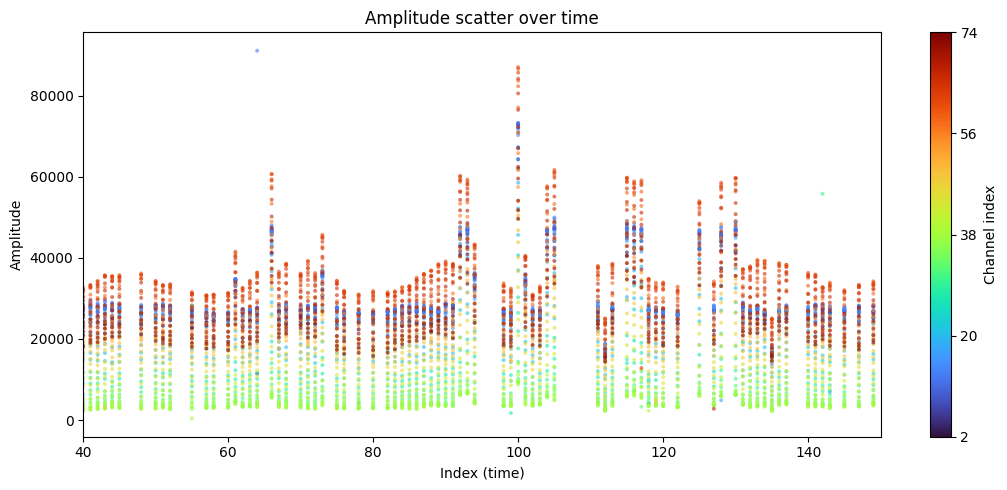

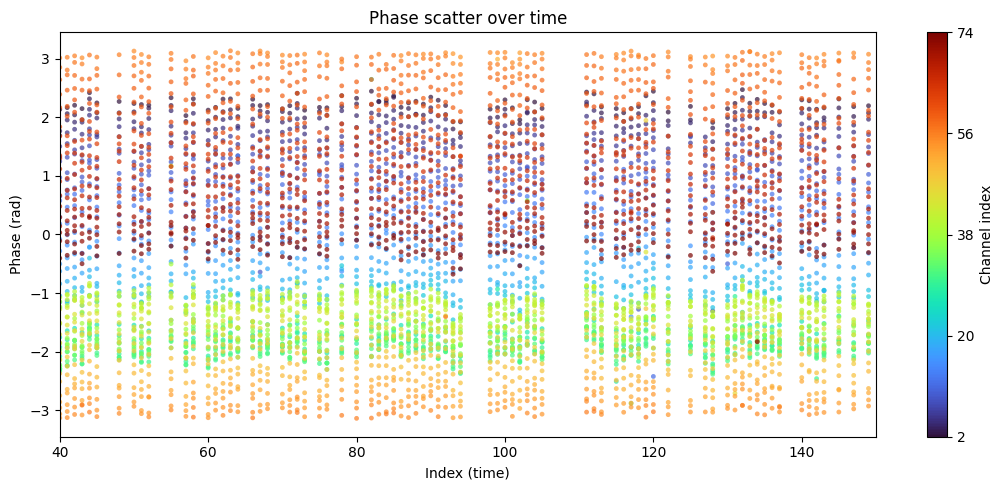

In [206]:
# -*- coding: utf-8 -*-
"""
样本级（entry 级）离群值预处理模块：
- 从 entries 中计算“跨信道代表幅值/相位”
- 基于代表幅值做稳健离群值检测（MAD 或分位数法）
- 返回过滤后的 entries 供后续绘图/频率估计使用

依赖：
- 你现有的 prepare_series_from_entries(entries, ap_index, ...)
- numpy, matplotlib 可选（仅示例使用）
"""

from typing import Callable, Dict, Any, List, Optional, Iterable, Tuple
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from typing import List, Dict, Any, Optional, Iterable, Tuple

DISABLED_REAL_CHS = {0, 1, 23, 24, 25, 77, 78, 79}

def prepare_series_from_entries(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    ensure_sorted_by_index: bool = True,
    channel_offset: int = 2,                 # 真实信道 = 源序号 + 2
    drop_disabled: bool = True,              # 是否丢弃禁用信道
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    将 entries 转为矩阵，并把源通道号（0..79）映射为真实信道号（+channel_offset）。
    - entries: list[dict]，每条含 e["channels"][src_ch] -> {I,Q,mag,phase_rad}
    - 返回的 chs 为“真实信道号”的有序列表（去除了禁用信道）。
    - channels_to_use 如果给的是“真实信道号”，也会正确筛选。
    """
    # 过滤 ap_index
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    if ensure_sorted_by_index:
        rows.sort(key=lambda e: int(e["index"]))
    x = np.array([int(e["index"]) for e in rows], dtype=int)

    # 1) 收集所有“源序号”->“真实信道号”的映射
    # 源序号可能以字符串存储，统一转 int
    src_to_real = {}
    all_real = set()
    for e in rows:
        for ch_str in e["channels"].keys():
            src = int(ch_str)
            real = src + channel_offset
            src_to_real[src] = real
            all_real.add(real)

    # 2) 选择实际使用的真实信道号集合
    if channels_to_use is None:
        real_chs = sorted(all_real)
    else:
        # 外部传入的 channels_to_use 视为“真实信道号”
        real_chs = sorted(int(c) for c in channels_to_use)

    # 3) 丢弃禁用信道
    if drop_disabled:
        real_chs = [c for c in real_chs if c not in DISABLED_REAL_CHS]

    # 4) 反向映射：真实->源序号（一个真实号只会对应一个源序号）
    real_to_src = {real: src for src, real in src_to_real.items() if real in real_chs}

    # 5) 初始化矩阵
    C = len(real_chs)
    N = len(rows)
    I = np.full((N, C), np.nan, dtype=float)
    Q = np.full((N, C), np.nan, dtype=float)
    MAG = np.full((N, C), np.nan, dtype=float)
    PH = np.full((N, C), np.nan, dtype=float)

    real_index_map = {real: i for i, real in enumerate(real_chs)}

    # 6) 填充矩阵（用源序号访问数据，填到真实号对应的列）
    for n, e in enumerate(rows):
        chan_dict = e["channels"]
        for ch_str, v in chan_dict.items():
            src = int(ch_str)
            real = src + channel_offset
            if real not in real_index_map:
                continue
            ci = real_index_map[real]
            Ii = float(v.get("I", np.nan))
            Qi = float(v.get("Q", np.nan))
            I[n, ci] = Ii
            Q[n, ci] = Qi
            MAG[n, ci] = float(v.get("mag", np.hypot(Ii, Qi)))
            PH[n, ci] = float(v.get("phase_rad", np.arctan2(Qi, Ii)))

    # 返回的 chs 是“真实信道号”
    return x, real_chs, I, Q, MAG, PH


def compute_sample_representatives(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    channel_offset: int = 2,
    drop_disabled: bool = True,
    zero_eps: float = 1e-12,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, List[int]]:
    """
    为每条样本（entry）计算“跨信道代表幅值”和“代表相位”（复数平均相位）。
    返回:
      - rep_mag: (N,) 每条样本的代表幅值（中位数, 屏蔽 NaN/全0）
      - rep_phase: (N,) 每条样本的代表相位（复数平均相位, 可能 NaN）
      - x_index: (N,) 样本的 index（与你的 prepare_series_from_entries 一致）
      - kept_row_indices: entries 中参与计算的行对应的全局下标（便于映射回 entries）
    """
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(
        entries, ap_index, channels_to_use, ensure_sorted_by_index=True,
        channel_offset=channel_offset, drop_disabled=drop_disabled
    )
    if MAG.size == 0:
        return np.array([]), np.array([]), np.array([]), []

    N, _ = MAG.shape
    rep_mag = np.full(N, np.nan, dtype=float)
    rep_phase = np.full(N, np.nan, dtype=float)

    for n in range(N):
        Ii = I[n, :]
        Qi = Q[n, :]
        MAGi = MAG[n, :]
        PHi = PH[n, :]

        is_nan = np.isnan(Ii) | np.isnan(Qi) | np.isnan(MAGi) | np.isnan(PHi)
        is_zero = (np.abs(MAGi) <= zero_eps) | ((np.abs(Ii) <= zero_eps) & (np.abs(Qi) <= zero_eps))
        msk = ~(is_nan | is_zero)
        if not np.any(msk):
            continue

        # 代表幅值：中位数（稳健，对重尾/个别爆点不敏感）
        rep_mag[n] = np.median(MAGi[msk])

        # 代表相位：只保留相位信息后做复数平均
        z = Ii[msk] + 1j * Qi[msk]
        z_norm = z / (np.abs(z) + 1e-12)
        z_mean = np.mean(z_norm)
        if np.isfinite(z_mean.real) and np.isfinite(z_mean.imag) and (np.abs(z_mean) > 0):
            rep_phase[n] = np.angle(z_mean)

    # 取得本 AP 对应的 rows 顺序（与 x 对齐）
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    rows.sort(key=lambda e: int(e["index"]))
    kept_row_indices = [entries.index(e) for e in rows]

    return rep_mag, rep_phase, x, kept_row_indices


def detect_outlier_samples(
    rep_mag: np.ndarray,
    method: str = "mad",           # "mad" | "quantile"
    mad_thresh: float = 3.5,       # Modified Z-score 阈值，常用 3~3.5
    q_low: float = 0.02,
    q_high: float = 0.98,
) -> np.ndarray:
    """
    输入每样本代表幅值，返回布尔掩码 keep_mask: True 表示保留该样本。
    """
    x = rep_mag.astype(float)
    valid = np.isfinite(x)

    if not np.any(valid):
        return np.zeros_like(valid, dtype=bool)

    if method == "mad":
        xm = np.median(x[valid])
        mad = np.median(np.abs(x[valid] - xm))
        eps = 1e-12
        if mad < eps:
            # 几乎不变，保留全部有效点
            keep = valid.copy()
        else:
            z = 0.6745 * (x - xm) / (mad + eps)
            keep = valid & (np.abs(z) <= mad_thresh)
    else:
        lo = np.quantile(x[valid], q_low)
        hi = np.quantile(x[valid], q_high)
        keep = valid & (x >= lo) & (x <= hi)

    return keep


def detect_outlier_samples_joint(
    MAG: np.ndarray,
    base_keep_mask: np.ndarray,
    zero_eps: float = 1e-12,
    frac_hi: float = 0.30,          # 高幅值通道的占比阈值
    hi_quantile: float = 0.98,      # 全局高阈的分位数
) -> np.ndarray:
    """
    在已有 keep_mask 基础上，增加“多信道共同异常”的规则：
    - 若某样本中，超过 hi_quantile 的通道比例 > frac_hi，则判为异常（置 False）。

    参数：
      - MAG: (N, C) 幅值矩阵
      - base_keep_mask: 初筛后的保留掩码（MAD/分位数）
    """
    keep = base_keep_mask.copy()
    if MAG.size == 0 or not np.any(keep):
        return keep

    # 计算全局的“高幅值”阈值（忽略 NaN/0）
    valid = np.isfinite(MAG) & (np.abs(MAG) > zero_eps)
    if not np.any(valid):
        return keep

    glb_hi = np.nanquantile(MAG[valid], hi_quantile)

    N, C = MAG.shape
    for n in range(N):
        if not keep[n]:
            continue
        col = MAG[n, :]
        msk = np.isfinite(col) & (np.abs(col) > zero_eps)
        if not np.any(msk):
            # 空样本：保留或丢弃都可以，默认保留
            continue
        frac = np.mean(col[msk] >= glb_hi)
        if frac > frac_hi:
            keep[n] = False
    return keep


def preprocess_entries_for_outliers(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    method: str = "mad",
    mad_thresh: float = 3.5,
    q_low: float = 0.02,
    q_high: float = 0.98,
    channel_offset: int = 2,
    drop_disabled: bool = True,
    apply_joint_rule: bool = True,
    joint_frac_hi: float = 0.30,
    joint_hi_quantile: float = 0.98,
) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
    """
    基于样本级“代表幅值”进行离群值过滤，返回过滤后的 entries 及信息。
    info 包含:
      - kept_indices: 过滤后保留的 entries 在原列表中的全局下标
      - dropped_indices: 被剔除的全局下标
      - rep_mag: (N,) 代表幅值序列
      - rep_phase: (N,) 代表相位序列（可用于调试/二次利用）
      - index_series: (N,) 样本 index（与 prepare_series_from_entries 的 x 对齐）
      - stats: 统计信息（中位数、MAD、保留数/剔除数等）
    """
    # 计算代表量
    rep_mag, rep_phase, x_index, kept_row_indices = compute_sample_representatives(
        entries, ap_index, channels_to_use, channel_offset, drop_disabled
    )
    if rep_mag.size == 0:
        return [], {
            "kept_indices": [],
            "dropped_indices": [],
            "rep_mag": rep_mag,
            "rep_phase": rep_phase,
            "index_series": x_index,
            "stats": {"kept": 0, "dropped": 0, "total": 0}
        }

    # 基础筛除（MAD/分位数）
    keep_mask_local = detect_outlier_samples(
        rep_mag, method=method, mad_thresh=mad_thresh, q_low=q_low, q_high=q_high
    )

    # 可选：联合规则（多信道共同异常）
    # 需要取 MAG 以便统计高幅值通道比例
    _, _, _, _, MAG, _ = prepare_series_from_entries(
        entries, ap_index, channels_to_use, ensure_sorted_by_index=True,
        channel_offset=channel_offset, drop_disabled=drop_disabled
    )
    if apply_joint_rule and MAG.size > 0:
        keep_mask_local = detect_outlier_samples_joint(
            MAG, keep_mask_local, frac_hi=joint_frac_hi, hi_quantile=joint_hi_quantile
        )

    kept_indices_global = [kept_row_indices[i] for i, k in enumerate(keep_mask_local) if k]
    dropped_indices_global = [kept_row_indices[i] for i, k in enumerate(keep_mask_local) if not k]
    filtered = [entries[i] for i in kept_indices_global]

    stats = {
        "method": method,
        "mad_thresh": mad_thresh,
        "q_low": q_low,
        "q_high": q_high,
        "median_rep_mag": float(np.nanmedian(rep_mag)) if rep_mag.size else np.nan,
        "mad_rep_mag": float(np.nanmedian(np.abs(rep_mag - np.nanmedian(rep_mag)))) if rep_mag.size else np.nan,
        "kept": len(kept_indices_global),
        "dropped": len(dropped_indices_global),
        "total": int(rep_mag.size),
        "apply_joint_rule": bool(apply_joint_rule),
        "joint_frac_hi": joint_frac_hi,
        "joint_hi_quantile": joint_hi_quantile,
    }

    info = {
        "kept_indices": kept_indices_global,
        "dropped_indices": dropped_indices_global,
        "rep_mag": rep_mag,
        "rep_phase": rep_phase,
        "index_series": x_index,
        "stats": stats,
    }
    return filtered, info

def filter_entries_by_magnitude_threshold(
    entries: List[Dict[str, Any]],
    ap_index: int,
    mag_min: Optional[float] = None,     # None 表示不设下限
    mag_max: Optional[float] = None,     # None 表示不设上限
    channels_to_use: Optional[Iterable[int]] = None,
    channel_offset: int = 2,
    drop_disabled: bool = True,
    treat_nan_as_outlier: bool = False,  # True: 只要某信道幅值是 NaN 也丢弃该样本
    zero_eps: float = 0.0,               # >0 时可把过小值视作 0（例如 1e-12）
) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
    """
    简单阈值规则：若某个样本的任意信道 MAG < mag_min 或 MAG > mag_max，则丢弃整个样本。

    返回:
      - filtered_entries: 通过阈值筛选后的 entries（仅包含 ap_index 指定的条目）
      - info: 统计信息（保留/丢弃的原始全局下标、数量等）
    """
    # 取该 AP 的矩阵视图
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(
        entries, ap_index, channels_to_use,
        ensure_sorted_by_index=True,
        channel_offset=channel_offset,
        drop_disabled=drop_disabled,
    )

    # 与 x 对齐的 entries 的全局下标（便于映射）
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    rows.sort(key=lambda e: int(e["index"]))
    kept_row_indices = [entries.index(e) for e in rows]

    if MAG.size == 0:
        return [], {
            "kept_indices": [],
            "dropped_indices": [],
            "total": 0,
            "ap_index": ap_index,
            "chs_used": chs,
            "mag_min": mag_min,
            "mag_max": mag_max,
        }

    # 构造样本级布尔掩码：True 表示保留
    N, C = MAG.shape
    keep_mask = np.ones(N, dtype=bool)

    # NaN 处理
    if treat_nan_as_outlier:
        # 任一信道是 NaN 就判为异常
        any_nan = np.any(~np.isfinite(MAG), axis=1)
        keep_mask &= ~any_nan

    # 过小值归零（可选）
    if zero_eps > 0.0:
        MAG_proc = MAG.copy()
        MAG_proc[np.isfinite(MAG_proc) & (np.abs(MAG_proc) < zero_eps)] = 0.0
    else:
        MAG_proc = MAG

    # 下限
    if mag_min is not None:
        too_small = np.any(MAG_proc < mag_min, axis=1)
        # 仅对有限值判断；NaN 已被上一步（若开启）处理
        too_small &= np.any(np.isfinite(MAG_proc), axis=1)
        keep_mask &= ~too_small

    # 上限
    if mag_max is not None:
        too_large = np.any(MAG_proc > mag_max, axis=1)
        too_large &= np.any(np.isfinite(MAG_proc), axis=1)
        keep_mask &= ~too_large

    kept_indices_global = [kept_row_indices[i] for i in range(N) if keep_mask[i]]
    dropped_indices_global = [kept_row_indices[i] for i in range(N) if not keep_mask[i]]

    filtered_entries = [entries[i] for i in kept_indices_global]

    info = {
        "ap_index": ap_index,
        "chs_used": chs,
        "mag_min": mag_min,
        "mag_max": mag_max,
        "treat_nan_as_outlier": treat_nan_as_outlier,
        "zero_eps": zero_eps,
        "kept": len(kept_indices_global),
        "dropped": len(dropped_indices_global),
        "total": int(N),
        "kept_indices": kept_indices_global,
        "dropped_indices": dropped_indices_global,
    }
    return filtered_entries, info

def plot_channels_scatter_over_time(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    mode: str = "amplitude",           # "magnitude" 或 "phase"
    channels_to_use: Optional[Iterable[int]] = None,
    max_channels: Optional[int] = None,
    unwrap_phase: bool = True,
    normalize_magnitude: bool = False,
    cmap_name: str = "turbo",          # 颜色按信道号渐变
    alpha: float = 0.7,
    s: float = 10.0,                   # 点大小
    edgecolors: str = "none",          # "none" 或 "face"
    title: Optional[str] = None,
    show_colorbar: bool = True,
):
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, channels_to_use)

    if max_channels is not None and len(chs) > max_channels:
        chs = chs[:max_channels]
        x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, chs)

    N, C = MAG.shape
    if C == 0 or N == 0:
        raise ValueError("没有可绘制的数据：检查 ap_index / channels_to_use 是否正确。")

    if mode == "phase":
        Y = PH.copy()
        if unwrap_phase:
            for c in range(C):
                col = Y[:, c]
                if np.all(np.isnan(col)):
                    continue
                Y[:, c] = np.unwrap(col)
        else:
            Y = ((Y + np.pi) % (2*np.pi)) - np.pi
        y_label = "Phase (rad, unwrapped)" if unwrap_phase else "Phase (rad)"
    else:
        Y = MAG.copy()
        if normalize_magnitude:
            for c in range(C):
                col = Y[:, c]
                m = np.nanmax(np.abs(col))
                if np.isfinite(m) and m > 0:
                    Y[:, c] = col / m
        y_label = "Amplitude (a.u.)" if normalize_magnitude else "Amplitude"

    # ch_min, ch_max = min(chs), max(chs)
    # normed = np.zeros(C) if ch_max == ch_min else (np.array(chs) - ch_min) / (ch_max - ch_min)
    
        # 颜色映射（保持不变）
    cmap = plt.get_cmap(cmap_name)
    ch_min, ch_max = min(chs), max(chs)
    norm = mpl.colors.Normalize(vmin=ch_min, vmax=ch_max)
    normed = norm(np.array(chs))
    # colors = [cmap(v) for v in normed]


    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(v) for v in normed]

    fig, ax = plt.subplots(figsize=(11, 5))

    # 逐信道画散点（每个信道一组）
    for ci, ch in enumerate(chs):
        yi = Y[:, ci]
        mask = np.isfinite(yi)
        if not np.any(mask):
            continue
        ax.scatter(x[mask], yi[mask], s=s, alpha=alpha, color=colors[ci], edgecolors=edgecolors, label=f"ch {ch}")

    ax.set_xlabel("Index (time)")
    ax.set_ylabel(y_label)
    if title is None:
        # title = f"{mode.capitalize()} scatter over time | ap_index={ap_index} | channels={len(chs)}"
        title = f"{mode.capitalize()} scatter over time"
    ax.set_title(title)
    # ax.grid(True, alpha=0.25)#暂时不启用格子

    # 对于信道多的情况，用颜色条表示信道号映射
    if len(chs) <= 15:
        ax.legend(ncol=3, fontsize=9)
    else:
        if show_colorbar:
            # sm = plt.cm.ScalarMappable(cmap=cmap)
            # sm.set_array([ch_min, ch_max])
            # cbar = plt.colorbar(sm, ax=ax)
            # cbar.set_label("Channel index")
            # cbar.set_ticks([0.0, 1.0])
            # cbar.set_ticklabels([str(ch_min), str(ch_max)])
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])  # 哑数据，避免警告
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Channel index")
                # 可选：自定义几个整型刻度
            ticks = np.linspace(ch_min, ch_max, num=5, dtype=int)
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([str(t) for t in ticks])
    
    plt.xlim(40,150)
    # plt.savefig(f'./ble.bre/finebre.fig/'+mode+'_variation.svg', dpi=300)
    plt.savefig(f'./ble.bre/finebre.fig/'+mode+'_variation.png', dpi=300)  
    plt.savefig(f'./ble.bre/finebre.fig/'+mode+'_variation.pdf', dpi=300) 
    plt.tight_layout()
    plt.show()




# =========================
# 示例：和你的绘图代码对接
# =========================


if __name__ == "__main__":
    # 假设你已有 data_to_parse, 以及真实的 prepare_series_from_entries 实现
    # from your_module import data_to_parse, prepare_series_from_entries, plot_channels_scatter_over_time
    # 这里仅示例调用流程：

    # 例：对 ap_index=0 做预处理
    ap = 0
    ch_use = range(75)  # 或 None 使用全部可用

    # 设置你自己的阈值（示例）
    MAG_MIN = 50.0
    MAG_MAX = 0.1e6

    filtered_entries, info = filter_entries_by_magnitude_threshold(
        entries=data_to_parse,
        ap_index=ap,
        mag_min=MAG_MIN,
        mag_max=MAG_MAX,
        channels_to_use=ch_use,
        treat_nan_as_outlier=False,  # 若希望任何 NaN 直接丢弃样本，改为 True
        zero_eps=1e-12,              # 把极小值当作 0，可按需设为 0.0 关闭
    )
    # 不滤波就直接原始数据
    # filtered_entries = data_to_parse


    # 2) 后续绘图/频率估计，一律使用 filtered_entries
    plot_channels_scatter_over_time(filtered_entries, ap_index=ap, mode="amplitude", channels_to_use=ch_use, s=8, alpha=0.6)
    plot_channels_scatter_over_time(filtered_entries, ap_index=ap, mode="phase", channels_to_use=ch_use, unwrap_phase=False, s=12)

    # 3) 若你需要使用时间戳而非 index，可从 filtered_entries 中取：
    # ts_ms = [e["meta"]["timestamp_ms"] for e in filtered_entries if e.get("meta") and "timestamp_ms" in e["meta"]]
    # t_s = np.array(ts_ms, dtype=float) / 1000.0

In [205]:
# -*- coding: utf-8 -*-
"""
融合分析：压电.npy 波形 vs BLE filtered_entries
功能：
1) 加载压电波形（.npy）与 BLE 过滤后的 entries
2) 手动裁剪两路数据的起止样本
3) 以压电为参考时间轴（50 Hz 等间隔），将 BLE 每个信道的幅值/相位按时间戳形成不等采样序列，并插值到压电时间轴
4) 计算每个信道：
   - 幅值序列与相位序列的主频（呼吸主频），不等采样时用 Lomb–Scargle，等采样时用 FFT
   - 与压电波形的 RMSE 和 Pearson 相关（先 z-score 归一化）
5) 打印结果

前置：
- 你已有 filtered_entries（同一 AP），其每个 entry 结构包含：
  - e["meta"]["timestamp_ms"]（毫秒）
  - e["channels"][src_ch] -> {I,Q,mag,phase_rad}
  - e["index"] 为样本序号（可用但我们主要用时间戳）
- 你已有 prepare_series_from_entries(entries, ap_index, ...) 实现（下方直接复用）
"""

from __future__ import annotations
import numpy as np
from typing import List, Dict, Any, Optional, Iterable, Tuple
from dataclasses import dataclass

# ========== 你现有的函数占位：请用你的真实实现 ==========
# def prepare_series_from_entries(
#     entries: List[Dict[str, Any]],
#     ap_index: int,
#     channels_to_use: Optional[Iterable[int]] = None,
#     ensure_sorted_by_index: bool = True,
#     channel_offset: int = 2,
#     drop_disabled: bool = True,
# ) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#     raise NotImplementedError("Use your existing prepare_series_from_entries implementation.")
# =======================================================

# ---------- 基础工具 ----------
def zscore(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    m = np.nanmean(x)
    s = np.nanstd(x)
    if not np.isfinite(s) or s == 0:
      # 如果标准差为0，返回零向量，避免除零
        return np.zeros_like(x, dtype=float)
    return (x - m) / s

def rmse(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    mask = np.isfinite(a) & np.isfinite(b)
    if not np.any(mask):
        return float("nan")
    a = a[mask]
    b = b[mask]
    if a.size == 0 or b.size == 0:
        return float("nan")
    return float(np.sqrt(np.mean((a - b) ** 2)))

def pearson_corr(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    mask = np.isfinite(a) & np.isfinite(b)
    if not np.any(mask):
        return float("nan")
    a = a[mask]
    b = b[mask]
    if a.size == 0 or b.size == 0:
        return float("nan")
    a0 = a - np.mean(a)
    b0 = b - np.mean(b)
    denom = np.sqrt(np.sum(a0**2) * np.sum(b0**2))
    if denom == 0:
        return float("nan")
    return float(np.sum(a0 * b0) / denom)

# ---------- 时间与插值 ----------
def extract_ble_time_series(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    channel_offset: int = 2,
    drop_disabled: bool = True,
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray]:
    """
    从 filtered_entries 提取 BLE 的时间戳（秒）与幅值/相位矩阵。
    返回：
      - t_ble: (N,) 秒，相对时间（从最早时间戳开始为0）
      - real_chs: List[int] 真实信道号
      - MAG: (N, C)
      - PH:  (N, C) 原始相位（弧度，未unwrap）
    """
    # 先用 prepare_series 取矩阵和 index 排序；我们改用时间戳排序
    x_idx, real_chs, I, Q, MAG, PH = prepare_series_from_entries(
        entries, ap_index, channels_to_use, ensure_sorted_by_index=True,
        channel_offset=channel_offset, drop_disabled=drop_disabled
    )

    # 提取与矩阵行对应的时间戳
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    rows.sort(key=lambda e: int(e["index"]))  # 与 prepare_series 对齐
    ts_ms = []
    for e in rows:
        ts = e.get("meta", {}).get("timestamp_ms", None)
        ts_ms.append(np.nan if ts is None else float(ts))
    t = np.array(ts_ms, dtype=float) / 1000.0
    # 相对时间
    if t.size > 0 and np.isfinite(t[0]):
        t0 = np.nanmin(t)
        t = t - t0
    else:
        t = np.arange(len(rows), dtype=float) * 0.3  # 兜底：约 0.3s 间隔

    # 按时间升序排序（若时间存在乱序情况）
    order = np.argsort(t)
    t_ble = t[order]
    MAG = MAG[order, :]
    PH = PH[order, :]

    return t_ble, real_chs, MAG, PH

def interp_to_ref_time(
    t_ref: np.ndarray,      # 参考时间轴（压电），等间隔
    t_src: np.ndarray,      # 源时间轴（BLE），不等间隔
    y_src: np.ndarray,      # 源数据 (N,) 或 (N,C)
) -> np.ndarray:
    """
    将源数据线性插值到参考时间轴。y_src 可为 (N,) 或 (N,C)。
    对于超出 t_src 边界的 t_ref，返回 NaN。
    """
    t_ref = np.asarray(t_ref, dtype=float)
    t_src = np.asarray(t_src, dtype=float)
    if y_src.ndim == 1:
        y_src = y_src[:, None]
    N, C = y_src.shape
    if N == 0 or t_src.size == 0:
        return np.full((t_ref.size, C), np.nan, dtype=float)

    y_out = np.full((t_ref.size, C), np.nan, dtype=float)
    # 仅对交集部分插值
    mask = (t_ref >= t_src.min()) & (t_ref <= t_src.max())
    if not np.any(mask):
        return y_out

    tq = t_ref[mask]
    for c in range(C):
        y_out[mask, c] = np.interp(tq, t_src, y_src[:, c].astype(float))
    return y_out

# ---------- 主频估计 ----------
def dominant_freq_lomb(t: np.ndarray, y: np.ndarray, fmin: float = 0.05, fmax: float = 1.0) -> float:
    """
    使用 Lomb–Scargle 估计主频（适合不等采样），返回 Hz。
    适用于 BLE 原始不等时间轴；若已插值到等间隔，也可用 FFT。
    """
    from scipy.signal import lombscargle
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    # 去均值，防止直流泄漏
    y0 = y - np.nanmean(y)
    # 清理 NaN
    mask = np.isfinite(t) & np.isfinite(y0)
    t = t[mask]
    y0 = y0[mask]
    if t.size < 5:
        return float("nan")

    # 自适应频率范围
    T = t.max() - t.min()
    if not np.isfinite(T) or T <= 0:
        return float("nan")
    if fmin is None:
        fmin = 1.0 / max(T, 1e-6)
    if fmax is None:
        # 估计中位采样间隔对应的 Nyquist
        dt_med = np.median(np.diff(np.sort(t)))
        fmax = 0.5 / dt_med if dt_med > 0 else 1.0

    # 呼吸常见 0.05~1 Hz 范围
    f1 = max(fmin, 0.01)
    f2 = min(fmax, 2.0)
    if f2 <= f1:
        f2 = f1 * 5.0
    freqs = np.linspace(f1, f2, 2048)
    pxx = lombscargle(t, y0, 2 * np.pi * freqs, precenter=True, normalize=True)
    if pxx.size == 0:
        return float("nan")
    return float(freqs[np.argmax(pxx)])

def dominant_freq_fft_uniform(y: np.ndarray, fs: float) -> float:
    """
    等采样序列的主频（FFT，取最大幅值的正频）。
    """
    y = np.asarray(y, dtype=float)
    if y.size < 4 or fs <= 0:
        return float("nan")
    y0 = y - np.nanmean(y)
    # 用 NaN 安全：若含 NaN，直接失败
    if np.any(~np.isfinite(y0)):
        return float("nan")
    n = y0.size
    # 频谱
    Y = np.fft.rfft(y0)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    if freqs.size <= 1:
        return float("nan")
    # 跳过直流分量
    mag = np.abs(Y)
    mag[0] = 0.0
    k = np.argmax(mag)
    return float(freqs[k])

# ---------- 主流程 ----------
@dataclass
class AnalysisConfig:
    piezo_npy_path: str
    ap_index: int = 0
    channels_to_use: Optional[Iterable[int]] = None  # 如 range(75)
    piezo_fs: float = 50.0
    # 手动裁剪：起止样本（半开区间），可为 None 表示不裁剪
    piezo_start: Optional[int] = None
    piezo_end: Optional[int] = None
    ble_start: Optional[int] = None  # 按“entry 顺序”裁剪（与按时间排序一致）
    ble_end: Optional[int] = None

def run_analysis(
    filtered_entries: List[Dict[str, Any]],
    cfg: AnalysisConfig,
) -> None:
    # 1) 加载压电波形 -> 重命名为“压电波形”
    piezo = np.load(cfg.piezo_npy_path).astype(float)  # 压电波形
    Np = piezo.size

    # 裁剪压电（按样本索引）
    s0 = cfg.piezo_start or 0
    s1 = cfg.piezo_end if cfg.piezo_end is not None else Np
    s0 = max(0, min(Np, s0))
    s1 = max(0, min(Np, s1))
    if s1 <= s0:
        raise ValueError("Invalid piezo slice range.")
    piezo = piezo[s0:s1]
    Np = piezo.size
    t_piezo = np.arange(Np, dtype=float) / float(cfg.piezo_fs)

    # 2) 提取 BLE 时间序列（相对时间）与矩阵 -> 重命名为“BLE信号”
    t_ble, real_chs, MAG, PH = extract_ble_time_series(
        filtered_entries, ap_index=cfg.ap_index, channels_to_use=cfg.channels_to_use
    )

    # 裁剪 BLE（按行顺序，对应时间升序）
    Nb = MAG.shape[0]
    b0 = cfg.ble_start or 0
    b1 = cfg.ble_end if cfg.ble_end is not None else Nb
    b0 = max(0, min(Nb, b0))
    b1 = max(0, min(Nb, b1))
    if b1 <= b0:
        raise ValueError("Invalid BLE slice range.")
    t_ble = t_ble[b0:b1]
    MAG = MAG[b0:b1, :]
    PH = PH[b0:b1, :]

    # 3) 将 BLE 插值到压电时间轴（每个信道一列）
    MAG_i = interp_to_ref_time(t_piezo, t_ble, MAG)  # shape (Np, C)
    # 相位：先按时间 unwrap，再插值
    # 我们需要对每个信道在 BLE 时间轴上展开，再插值
    PH_un = PH.copy()
    for c in range(PH_un.shape[1]):
        col = PH_un[:, c]
        mask = np.isfinite(col)
        if np.sum(mask) >= 2:
            # 仅对有效段 unwrap，再放回
            tmp = col[mask]
            tmp_un = np.unwrap(tmp)
            PH_un[mask, c] = tmp_un
    PH_i = interp_to_ref_time(t_piezo, t_ble, PH_un)

    # 4) 每个信道：主频 + 与压电的 RMSE / 相关（先 Z-score 规范化）
    fs_p = float(cfg.piezo_fs)
    # 压电主频（可记录参考）
    piezo_main_f = dominant_freq_fft_uniform(piezo, fs_p)

    # 压电归一化
    piezo_z = zscore(piezo)

    C = MAG_i.shape[1]
    results = []
    for ci in range(C):
        ch = real_chs[ci]

        # 主频：用 BLE 原始不等时间轴来估计，比插值稳健
        # 幅值
        mag_raw = MAG[:, ci].astype(float)
        mag_f = dominant_freq_lomb(t_ble, mag_raw, fmin=0.05, fmax=1.0)
        # 相位（展开后）
        ph_raw = PH_un[:, ci].astype(float)
        ph_f = dominant_freq_lomb(t_ble, ph_raw, fmin=0.05, fmax=1.0)

        # 与压电比较（在压电时间轴上）
        mag_i = MAG_i[:, ci]
        ph_i = PH_i[:, ci]

        mag_i_z = zscore(mag_i)
        ph_i_z = zscore(ph_i)

        amp_rmse = rmse(mag_i_z, piezo_z)
        amp_pear = pearson_corr(mag_i_z, piezo_z)

        phase_rmse = rmse(ph_i_z, piezo_z)
        phase_pear = pearson_corr(ph_i_z, piezo_z)

        results.append((ch, mag_f, ph_f, amp_rmse, amp_pear, phase_rmse, phase_pear))

    # 5) 打印结果
    print(f"Piezo main freq (ref): {piezo_main_f:.3f} Hz")
    for ch, mag_f, ph_f, amp_rmse, amp_pear, phase_rmse, phase_pear in results:
        print(f"ch{ch}: amp_fft:{mag_f:.3f}Hz; phase_fft:{ph_f:.3f}Hz; "
              f"amp_rmse:{amp_rmse:.4f}; amp_pearson:{amp_pear:.4f}; "
              f"phase_rmse:{phase_rmse:.4f}; phase_pearson:{phase_pear:.4f}")


# =========================
# 使用示例
# =========================
if __name__ == "__main__":
    # 假设你已有 filtered_entries（同一 AP），以及 prepare_series_from_entries 的可用实现
    # from your_module import filtered_entries, prepare_series_from_entries

    cfg = AnalysisConfig(
        # piezo_npy_path="./ble.bre/Data/"+"txt_filepiezo_waveform.npy",
         piezo_npy_path="./ble.bre/Data/ble.bre/Data/"+"20250828174138_578.txtpiezo_waveform.npy",
        ap_index=0,
        channels_to_use=range(75),  # 或 None
        piezo_fs=50.0,
        # 手动裁剪（示例值，按需修改）：
        piezo_start=200,   # 压电起始样本索引（可 None）
        piezo_end=2500,    # 压电终止样本索引（可 None）
        ble_start=40,       # BLE 起始样本（按时间排序后的序号）
        ble_end=170,      # BLE 终止样本
    )

    # 运行分析
    run_analysis(filtered_entries, cfg)

Piezo main freq (ref): 0.152 Hz
ch2: amp_fft:0.438Hz; phase_fft:0.691Hz; amp_rmse:1.4374; amp_pearson:-0.0204; phase_rmse:1.3169; phase_pearson:0.1435
ch3: amp_fft:0.438Hz; phase_fft:0.072Hz; amp_rmse:1.4214; amp_pearson:-0.0207; phase_rmse:1.2947; phase_pearson:0.1533
ch4: amp_fft:0.438Hz; phase_fft:0.693Hz; amp_rmse:1.3861; amp_pearson:0.0339; phase_rmse:1.2403; phase_pearson:0.2264
ch5: amp_fft:0.435Hz; phase_fft:0.050Hz; amp_rmse:1.4392; amp_pearson:-0.0241; phase_rmse:1.2485; phase_pearson:0.2293
ch6: amp_fft:0.437Hz; phase_fft:0.500Hz; amp_rmse:1.3704; amp_pearson:0.0152; phase_rmse:1.3818; phase_pearson:-0.0013
ch7: amp_fft:0.436Hz; phase_fft:0.050Hz; amp_rmse:1.3968; amp_pearson:0.0325; phase_rmse:1.3442; phase_pearson:0.1042
ch8: amp_fft:0.119Hz; phase_fft:0.102Hz; amp_rmse:1.3865; amp_pearson:0.0200; phase_rmse:1.3120; phase_pearson:0.1226
ch9: amp_fft:0.282Hz; phase_fft:0.647Hz; amp_rmse:1.3336; amp_pearson:0.0970; phase_rmse:1.3665; phase_pearson:0.0519
ch10: amp_fft:0.279H

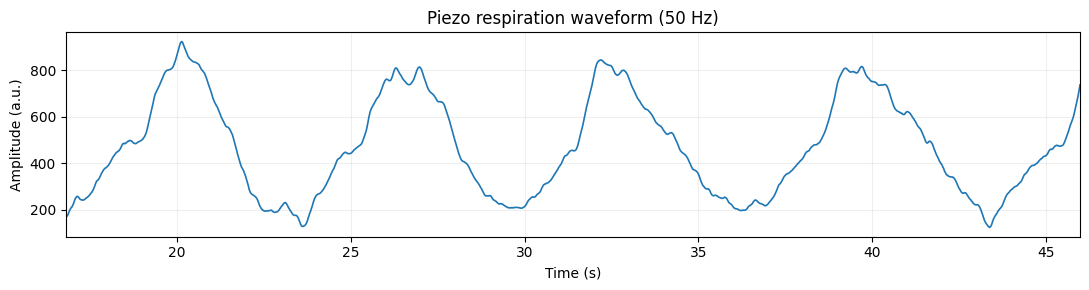

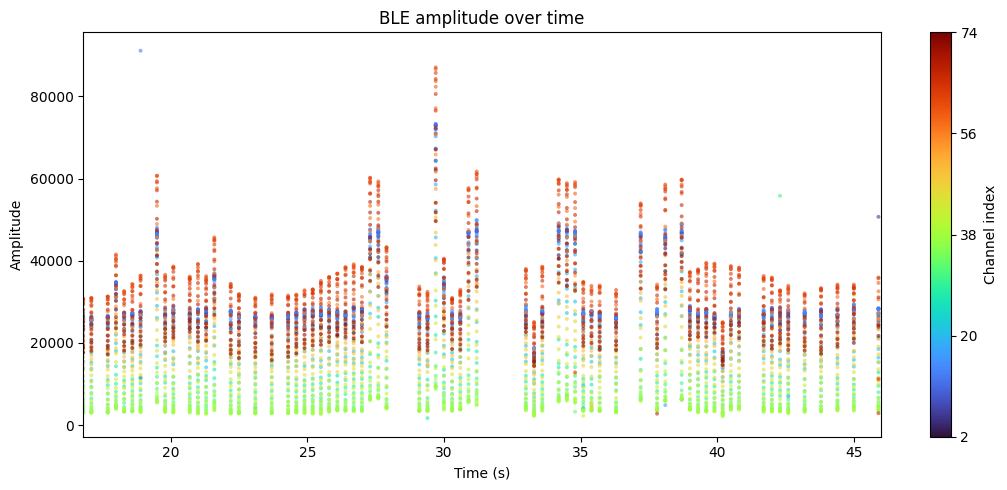

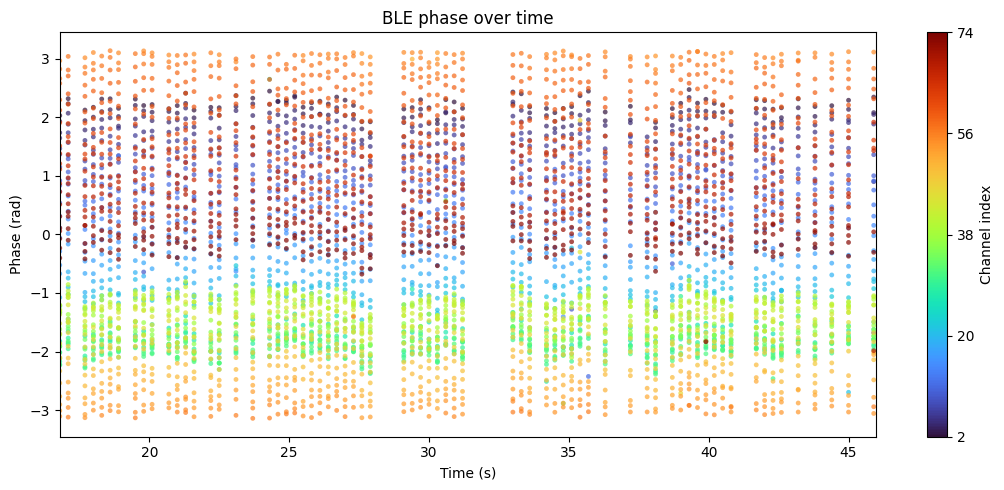

In [204]:
# -*- coding: utf-8 -*-
"""
在手动指定起止样本基础上，同步并绘制：
- 压电波形（50 Hz 等间隔）
- BLE 幅值/相位（按时间戳，相对时间对齐），各自一张图（幅值一张、相位一张），
  使用你提供的 plot_channels_scatter_over_time（稍作改造以支持按时间裁剪与时间轴为秒）。

功能摘要
1) 载入压电 .npy，裁剪 [piezo_start:piezo_end]（样本索引，50 Hz）
2) 从 filtered_entries 读取时间戳（秒，相对起点），并按 [ble_start:ble_end] 裁剪（样本序号）
3) 绘制：
   - 压电波形：时间轴秒
   - BLE 幅值散点：时间轴秒，限制 xlim 到交集时间窗
   - BLE 相位散点：可选 unwrap，时间轴秒，限制 xlim 到交集时间窗
注意：
- 需要你现有的 prepare_series_from_entries 函数。
- 你提供的 plot_channels_scatter_over_time 已整合在下方，新增了：
  - time_axis="index"|"seconds" 选项（默认 "seconds"）
  - x_seconds 参数（与矩阵行对齐的相对时间秒）
  - xlim_sec 参数控制 x 轴范围（秒）
  - subset_rows 参数用于根据 ble_start/ble_end 裁剪
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from typing import List, Dict, Any, Optional, Iterable, Tuple

# ========== 你现有的函数占位 ==========
# def prepare_series_from_entries(
#     entries: List[Dict[str, Any]],
#     ap_index: int,
#     channels_to_use: Optional[Iterable[int]] = None,
#     ensure_sorted_by_index: bool = True,
#     channel_offset: int = 2,
#     drop_disabled: bool = True,
# ) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#     raise NotImplementedError("Use your existing prepare_series_from_entries implementation.")
# =====================================

# --------- 提取 BLE 相对时间（秒）并按 index 顺序对齐矩阵 ----------
def extract_ble_time_and_mats(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    channels_to_use: Optional[Iterable[int]] = None,
    channel_offset: int = 2,
    drop_disabled: bool = True,
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray]:
    """
    返回：
      - t_ble_s: (N,) 相对时间秒（以本段最早时间戳为0）
      - chs: List[int] 信道列表
      - MAG: (N, C)
      - PH:  (N, C) 相位（弧度，未 unwrap）
    矩阵行序与 prepare_series_from_entries 的 x（按 index 排序）一致。
    """
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(
        entries, ap_index, channels_to_use, ensure_sorted_by_index=True,
        channel_offset=channel_offset, drop_disabled=drop_disabled
    )
    # 收集与行对应的时间戳
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    rows.sort(key=lambda e: int(e["index"]))
    ts_ms = [e.get("meta", {}).get("timestamp_ms", None) for e in rows]
    t = np.array([np.nan if v is None else float(v) for v in ts_ms], dtype=float) / 1000.0
    if t.size > 0 and np.any(np.isfinite(t)):
        t0 = np.nanmin(t[np.isfinite(t)])
        t = t - t0
    else:
        # 兜底：约 0.3 s 间隔
        t = np.arange(MAG.shape[0], dtype=float) * 0.3
    return t, chs, MAG, PH

# --------- 你的散点图函数：加入时间轴/裁剪支持 ----------
def plot_channels_scatter_over_time(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    mode: str = "amplitude",           # "amplitude" 或 "phase"
    channels_to_use: Optional[Iterable[int]] = None,
    max_channels: Optional[int] = None,
    unwrap_phase: bool = True,
    normalize_magnitude: bool = False,
    cmap_name: str = "turbo",
    alpha: float = 0.7,
    s: float = 10.0,
    edgecolors: str = "none",
    title: Optional[str] = None,
    show_colorbar: bool = True,
    # 新增：
    time_axis: str = "seconds",        # "seconds" 或 "index"
    x_seconds: Optional[np.ndarray] = None,  # 与矩阵行对齐的时间轴（秒）
    subset_rows: Optional[slice] = None,     # 行裁剪（ble_start:ble_end）
    xlim_sec: Optional[Tuple[float, float]] = None,  # x 轴范围（秒）
):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    x_idx, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, channels_to_use)

    if max_channels is not None and len(chs) > max_channels:
        chs = chs[:max_channels]
        x_idx, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, chs)

    N, C = MAG.shape
    if C == 0 or N == 0:
        raise ValueError("没有可绘制的数据：检查 ap_index / channels_to_use 是否正确。")

    # 行裁剪（与外部 ble_start/ble_end 一致）
    if subset_rows is not None:
        x_idx = x_idx[subset_rows]
        MAG = MAG[subset_rows, :]
        PH = PH[subset_rows, :]

    if mode == "phase":
        Y = PH.copy()
        if unwrap_phase:
            for c in range(Y.shape[1]):
                col = Y[:, c]
                if np.all(np.isnan(col)):
                    continue
                Y[:, c] = np.unwrap(col)
        else:
            Y = ((Y + np.pi) % (2*np.pi)) - np.pi
        y_label = "Phase (rad, unwrapped)" if unwrap_phase else "Phase (rad)"
    else:
        Y = MAG.copy()
        if normalize_magnitude:
            for c in range(Y.shape[1]):
                col = Y[:, c]
                m = np.nanmax(np.abs(col))
                if np.isfinite(m) and m > 0:
                    Y[:, c] = col / m
        y_label = "Amplitude (a.u.)" if normalize_magnitude else "Amplitude"

    # 决定 x 轴
    if time_axis == "seconds":
        if x_seconds is None:
            # 若未提供，尝试从 entries 中提取
            t_ble, _, _, _ = extract_ble_time_and_mats(entries, ap_index, channels_to_use)
            if subset_rows is not None:
                x = t_ble[subset_rows]
            else:
                x = t_ble
        else:
            x = x_seconds if subset_rows is None else x_seconds[subset_rows]
        x_label = "Time (s)"
    else:
        x = x_idx if subset_rows is None else x_idx[subset_rows]
        x_label = "Index"

    # 颜色映射
    cmap = plt.get_cmap(cmap_name)
    ch_min, ch_max = min(chs), max(chs)
    norm = mpl.colors.Normalize(vmin=ch_min, vmax=ch_max)
    colors = [cmap(norm(ch)) for ch in chs]

    fig, ax = plt.subplots(figsize=(11, 5))
    for ci, ch in enumerate(chs):
        yi = Y[:, ci]
        mask = np.isfinite(yi)
        if not np.any(mask):
            continue
        ax.scatter(x[mask], yi[mask], s=s, alpha=alpha, color=colors[ci], edgecolors=edgecolors, label=f"ch {ch}")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title or (f"{mode.capitalize()} scatter over time"))
    if len(chs) <= 15:
        ax.legend(ncol=3, fontsize=9)
    else:
        if show_colorbar:
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Channel index")
            ticks = np.linspace(ch_min, ch_max, num=5, dtype=int)
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([str(t) for t in ticks])

    if xlim_sec is not None and time_axis == "seconds":
        ax.set_xlim(xlim_sec[0], xlim_sec[1])

    plt.tight_layout()
    plt.show()

# --------- 压电绘图 ----------
def plot_piezo_timeseries(t: np.ndarray, y: np.ndarray, title: str = "Piezo waveform", xlim: Optional[Tuple[float, float]] = None):
    plt.figure(figsize=(11, 3))
    plt.plot(t, y, color="tab:blue", lw=1.2)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(title)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(f'./ble.bre/finebre.fig/'+'pizeio_variation.png', dpi=300)  
    plt.savefig(f'./ble.bre/finebre.fig/'+'pizeio_variation.pdf', dpi=300) 
    plt.show()

# --------- 主入口：加载、裁剪、对齐并绘制 ----------
def visualize_piezo_and_ble(
    piezo_npy_path: str | Path,
    filtered_entries_to_plot: List[Dict[str, Any]],
    ap_index: int = 0,
    channels_to_use: Optional[Iterable[int]] = None,
    # 手动样本裁剪
    piezo_start: Optional[int] = None,
    piezo_end: Optional[int] = None,
    ble_start: Optional[int] = None,
    ble_end: Optional[int] = None,
    piezo_fs: float = 50.0,
    unwrap_phase_for_plot: bool = True,
    normalize_ble_amp: bool = False,
):
    # 1) 压电：加载 + 样本裁剪 + 时间轴（秒）
    piezo = np.load(piezo_npy_path).astype(float)
    Np = piezo.size
    s0 = piezo_start or 0
    s1 = piezo_end if piezo_end is not None else Np
    s0 = max(0, min(Np, s0))
    s1 = max(0, min(Np, s1))
    if s1 <= s0:
        raise ValueError("Invalid piezo slice range.")
    piezo = piezo[s0:s1]
    t_piezo = np.arange(piezo.size, dtype=float) / float(piezo_fs)

    # 2) BLE：提取相对时间（秒）与矩阵
    t_ble, chs, MAG, PH = extract_ble_time_and_mats(filtered_entries_to_plot, ap_index, channels_to_use)

    # BLE 样本裁剪（按序号）
    Nb = MAG.shape[0]
    b0 = ble_start or 0
    b1 = ble_end if ble_end is not None else Nb
    b0 = max(0, min(Nb, b0))
    b1 = max(0, min(Nb, b1))
    if b1 <= b0:
        raise ValueError("Invalid BLE slice range.")
    subset = slice(b0, b1)
    t_ble_sel = t_ble[subset]

    # 3) 决定共同的时间显示窗口（取交集）
    tmin = max(0.0, float(np.min(t_ble_sel)) if t_ble_sel.size else 0.0)
    tmax = min(float(t_piezo[-1]), float(np.max(t_ble_sel)) if t_ble_sel.size else float(t_piezo[-1]))
    if tmax <= tmin:
        # 若没有交集，退化为各自范围
        piezo_xlim = (0.0, float(t_piezo[-1]))
        ble_xlim = (float(np.min(t_ble_sel)), float(np.max(t_ble_sel))) if t_ble_sel.size else (0.0, 0.0)
        print("Warning: No overlap in time ranges between piezo and BLE.")
    else:
        piezo_xlim = (tmin, tmax)
        ble_xlim = (tmin, tmax)

    # 4) 绘制压电
    plot_piezo_timeseries(t_piezo, piezo, title="Piezo respiration waveform (50 Hz)", xlim=piezo_xlim)

    # 5) 绘制 BLE 幅值散点（时间轴：秒）
    plot_channels_scatter_over_time(
        filtered_entries_to_plot,
        ap_index=ap_index,
        mode="amplitude",
        channels_to_use=channels_to_use,
        max_channels=None,
        # unwrap_phase=True,
        normalize_magnitude=normalize_ble_amp,
        cmap_name="turbo",
        alpha=0.6,
        s=8.0,
        edgecolors="none",
        title="BLE amplitude over time",
        show_colorbar=True,
        time_axis="seconds",
        x_seconds=t_ble,
        subset_rows=subset,
        xlim_sec=ble_xlim,
    )

    # 6) 绘制 BLE 相位散点（时间轴：秒）
    plot_channels_scatter_over_time(
        filtered_entries_to_plot,
        ap_index=ap_index,
        mode="phase",
        channels_to_use=channels_to_use,
        max_channels=None,
        unwrap_phase=False,
        # normalize_magnitude=False,
        cmap_name="turbo",
        # alpha=0.,
        s=12.0,
        edgecolors="none",
        title="BLE phase over time",
        show_colorbar=True,
        time_axis="seconds",
        x_seconds=t_ble,
        subset_rows=subset,
        xlim_sec=ble_xlim,
    )
    

# =========================
# 使用示例
# =========================
if __name__ == "__main__":
    # 假设你已有 filtered_entries（同一 AP）和 prepare_series_from_entries 的实现
    # from your_module import filtered_entries, prepare_series_from_entries
    # plot_channels_scatter_over_time(filtered_entries, ap_index=ap, mode="amplitude", channels_to_use=ch_use, s=8, alpha=0.6)
    # plot_channels_scatter_over_time(filtered_entries, ap_index=ap, mode="phase", channels_to_use=ch_use, unwrap_phase=False, s=12)

    visualize_piezo_and_ble(
        piezo_npy_path="./ble.bre/Data/ble.bre/Data/"+"20250828174138_578.txtpiezo_waveform.npy",
        filtered_entries_to_plot=filtered_entries,
        ap_index=0,
        channels_to_use=range(75),   # 或 None
        # 手动指定起止样本
        piezo_start=200,
        piezo_end=2500,
        ble_start=40,
        ble_end=170,
        piezo_fs=50.0,
        unwrap_phase_for_plot=False,
        normalize_ble_amp=False,
    )

# plot_channels_scatter_over_time(filtered_entries, ap_index=ap, mode="amplitude", channels_to_use=ch_use, s=8, alpha=0.6)
# plot_channels_scatter_over_time(filtered_entries, ap_index=ap, mode="phase", channels_to_use=ch_use, unwrap_phase=False, s=12)

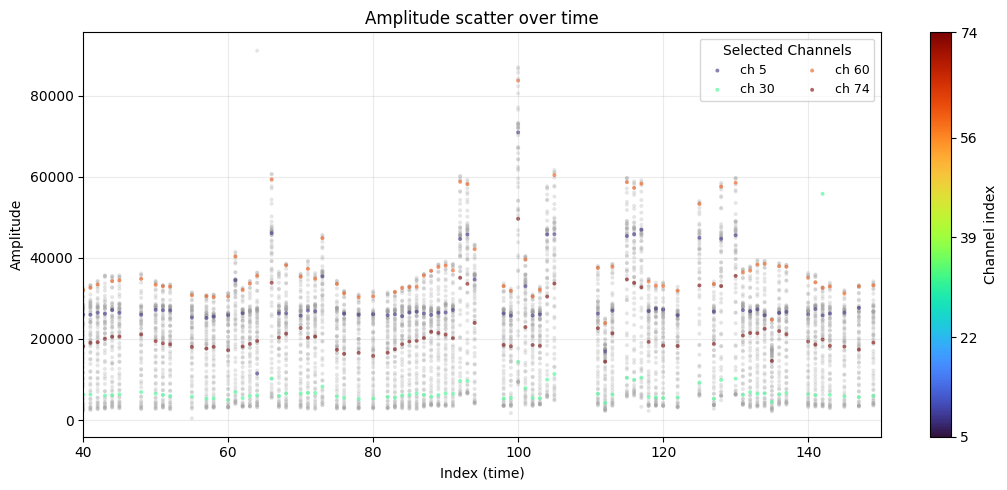

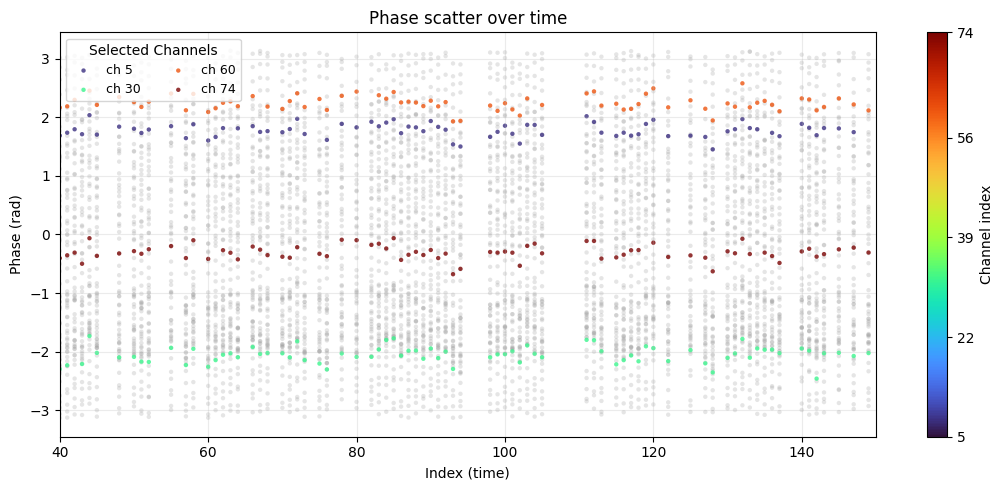

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import List, Dict, Any, Optional, Iterable, Tuple

# 使用示例

# 幅值散点，先做鲁棒去极值（MAD，4σ），并限制相邻样本最大跳变为 3000：
# plot_channels_scatter_over_time(entries, ap_index=0, mode="magnitude", channels_to_use=range(75), apply_filter=True, filter_method="mad", filter_k=4.0, filter_max_step=3000, s=8, alpha=0.6)
# 相位散点，unwrap，用 IQR 过滤，k=3，并只高亮信道 [5, 22, 60]，其他通道灰色淡化：
# plot_channels_scatter_over_time(entries, ap_index=0, mode="phase", channels_to_use=range(75), unwrap_phase=True, apply_filter=True, filter_method="iqr", filter_k=3.0, highlight_channels=[5,22,60], grey_out_others=True, s=10)
# 参数建议

# filter_k：MAD 模式下 35 较常用；IQR 下 1.53.0 常见。
# filter_max_step：根据你的“正常变化范围”设定。如果幅值正常在 2万上下轻微波动，而异常能跳到 5万，可试 2500~4000。
# mode="clip" 会把极端值拉回阈值边界，曲线连续但不显示离群值；默认 "mask" 会直接置 NaN，让这些点不参与绘制。


# ---------- 数据准备（同前） ----------
import numpy as np
from typing import List, Dict, Any, Optional, Iterable, Tuple

DISABLED_REAL_CHS = {0, 1, 23, 24, 25, 77, 78, 79}

def prepare_series_from_entries(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    ensure_sorted_by_index: bool = True,
    channel_offset: int = 2,                 # 真实信道 = 源序号 + 2
    drop_disabled: bool = True,              # 是否丢弃禁用信道
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    将 entries 转为矩阵，并把源通道号（0..79）映射为真实信道号（+channel_offset）。
    - entries: list[dict]，每条含 e["channels"][src_ch] -> {I,Q,mag,phase_rad}
    - 返回的 chs 为“真实信道号”的有序列表（去除了禁用信道）。
    - channels_to_use 如果给的是“真实信道号”，也会正确筛选。
    """
    # 过滤 ap_index
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    if ensure_sorted_by_index:
        rows.sort(key=lambda e: int(e["index"]))
    x = np.array([int(e["index"]) for e in rows], dtype=int)

    # 1) 收集所有“源序号”->“真实信道号”的映射
    # 源序号可能以字符串存储，统一转 int
    src_to_real = {}
    all_real = set()
    for e in rows:
        for ch_str in e["channels"].keys():
            src = int(ch_str)
            real = src + channel_offset
            src_to_real[src] = real
            all_real.add(real)

    # 2) 选择实际使用的真实信道号集合
    if channels_to_use is None:
        real_chs = sorted(all_real)
    else:
        # 外部传入的 channels_to_use 视为“真实信道号”
        real_chs = sorted(int(c) for c in channels_to_use)

    # 3) 丢弃禁用信道
    if drop_disabled:
        real_chs = [c for c in real_chs if c not in DISABLED_REAL_CHS]

    # 4) 反向映射：真实->源序号（一个真实号只会对应一个源序号）
    real_to_src = {real: src for src, real in src_to_real.items() if real in real_chs}

    # 5) 初始化矩阵
    C = len(real_chs)
    N = len(rows)
    I = np.full((N, C), np.nan, dtype=float)
    Q = np.full((N, C), np.nan, dtype=float)
    MAG = np.full((N, C), np.nan, dtype=float)
    PH = np.full((N, C), np.nan, dtype=float)

    real_index_map = {real: i for i, real in enumerate(real_chs)}

    # 6) 填充矩阵（用源序号访问数据，填到真实号对应的列）
    for n, e in enumerate(rows):
        chan_dict = e["channels"]
        for ch_str, v in chan_dict.items():
            src = int(ch_str)
            real = src + channel_offset
            if real not in real_index_map:
                continue
            ci = real_index_map[real]
            Ii = float(v.get("I", np.nan))
            Qi = float(v.get("Q", np.nan))
            I[n, ci] = Ii
            Q[n, ci] = Qi
            MAG[n, ci] = float(v.get("mag", np.hypot(Ii, Qi)))
            PH[n, ci] = float(v.get("phase_rad", np.arctan2(Qi, Ii)))

    # 返回的 chs 是“真实信道号”
    return x, real_chs, I, Q, MAG, PH


# ---------- 异常值过滤 ----------
def robust_filter_per_channel(
    Y: np.ndarray,
    method: str = "mad",  # "mad" 或 "iqr"
    k: float = 4.0,  # 阈值倍数（越大越宽松）
    max_step: Optional[
        float
    ] = None,  # 相邻样本允许的最大跳变（绝对值），超过则视为异常
    mode: str = "mask",  # "mask"=置为NaN；"clip"=裁剪到阈值边界
) -> Tuple[np.ndarray, np.ndarray]:
    """
    对每列（每个信道）进行鲁棒去极值。
    返回 (Y_filtered, mask_kept)；mask_kept=True 表示保留的点。
    """
    Y = np.asarray(Y, dtype=float)
    N, C = Y.shape
    Yf = Y.copy()
    keep = np.isfinite(Yf)

    for c in range(C):
        col = Yf[:, c]
        finite = np.isfinite(col)
        if not np.any(finite):
            continue
        xc = col[finite]
        if method == "mad":
            med = np.median(xc)
            mad = np.median(np.abs(xc - med))
            # 1.4826 为将 MAD 近似转化为标准差的因子
            sigma = 1.4826 * mad if mad > 0 else np.std(xc)
            lo, hi = med - k * sigma, med + k * sigma
        else:  # iqr
            q1, q3 = np.percentile(xc, [25, 75])
            iqr = q3 - q1
            lo, hi = q1 - k * iqr, q3 + k * iqr

        # 基于范围的过滤
        too_low = col < lo
        too_high = col > hi
        bad = (too_low | too_high) & finite

        # 基于最大跳变的过滤（可选）
        if max_step is not None and N >= 2:
            diff = np.abs(np.diff(col))
            jump_bad = np.zeros_like(col, dtype=bool)
            jump_bad[1:] |= diff > max_step
            jump_bad[:-1] |= diff > max_step
            bad |= jump_bad & finite

        if mode == "mask":
            col[bad] = np.nan
        else:  # "clip"
            col = np.clip(col, lo, hi)
            # 再把跳变异常置 NaN（若启用）
            if max_step is not None and N >= 2:
                col[jump_bad] = np.nan

        Yf[:, c] = col
        keep[:, c] &= np.isfinite(col)

    return Yf, keep


# ---------- 散点图，支持高亮与颜色条修复 ----------
def plot_channels_scatter_over_time(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    mode: str = "amplitude",  # "magnitude" 或 "phase"
    channels_to_use: Optional[Iterable[int]] = None,
    max_channels: Optional[int] = None,
    unwrap_phase: bool = True,
    normalize_magnitude: bool = False,
    # 异常值过滤参数（可为 None 关闭）
    apply_filter: bool = True,
    filter_method: str = "mad",
    filter_k: float = 4.0,
    filter_max_step: Optional[float] = None,
    filter_mode: str = "mask",
    # 高亮相关
    highlight_channels: Optional[Iterable[int]] = None,
    grey_out_others: bool = True,
    base_grey: Tuple[float, float, float] = (0.6, 0.6, 0.6),
    base_alpha: float = 0.25,
    # 点样式
    cmap_name: str = "turbo",
    alpha: float = 0.8,
    s: float = 10.0,
    edgecolors: str = "none",
    title: Optional[str] = None,
    show_colorbar: bool = True,
):
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(
        entries, ap_index, channels_to_use
    )

    if max_channels is not None and len(chs) > max_channels:
        chs = chs[:max_channels]
        x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, chs)

    N, C = MAG.shape
    if C == 0 or N == 0:
        raise ValueError("没有可绘制的数据：检查 ap_index / channels_to_use 是否正确。")

    # 选择量
    if mode == "phase":
        Y = PH.copy()
        if unwrap_phase:
            for c in range(C):
                col = Y[:, c]
                if np.all(np.isnan(col)):
                    continue
                Y[:, c] = np.unwrap(col)
        else:
            Y = ((Y + np.pi) % (2 * np.pi)) - np.pi
        y_label = "Phase (rad, unwrapped)" if unwrap_phase else "Phase (rad)"
    else:
        Y = MAG.copy()
        if normalize_magnitude:
            for c in range(C):
                col = Y[:, c]
                m = np.nanmax(np.abs(col))
                if np.isfinite(m) and m > 0:
                    Y[:, c] = col / m
        y_label = "Amplitude (a.u.)" if normalize_magnitude else "Amplitude"

    # 异常值过滤
    if apply_filter:
        Y, keep_mask = robust_filter_per_channel(
            Y,
            method=filter_method,
            k=filter_k,
            max_step=filter_max_step,
            mode=filter_mode,
        )
    else:
        keep_mask = np.isfinite(Y)

    # 颜色映射与 colorbar（使用 Normalize，避免错位）
    ch_min, ch_max = min(chs), max(chs)
    cmap = plt.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=ch_min, vmax=ch_max)

    fig, ax = plt.subplots(figsize=(11, 5))

    # 高亮集合
    hi_set = set(int(c) for c in (highlight_channels or []))

    # 先画“非高亮”的基底（灰色）
    if grey_out_others:
        for ci, ch in enumerate(chs):
            if ch in hi_set:
                continue
            yi = Y[:, ci]
            mask = np.isfinite(yi) & keep_mask[:, ci]
            if not np.any(mask):
                continue
            ax.scatter(
                x[mask],
                yi[mask],
                s=s,
                alpha=base_alpha,
                color=base_grey,
                edgecolors=edgecolors,
                label=None,
            )

    # 再画“高亮”或全部使用色图的曲线
    for ci, ch in enumerate(chs):
        # 若设置了高亮，仅对高亮通道使用色图；否则所有通道都用色图
        if highlight_channels is not None and ch not in hi_set:
            continue
        yi = Y[:, ci]
        mask = np.isfinite(yi) & keep_mask[:, ci]
        if not np.any(mask):
            continue
        ax.scatter(
            x[mask],
            yi[mask],
            s=s,
            alpha=alpha,
            color=cmap(norm(ch)),
            edgecolors=edgecolors,
            label=f"ch {ch}",
        )

    ax.set_xlabel("Index (time)")
    ax.set_ylabel(y_label)
    if title is None:
        title = f"{mode.capitalize()} scatter over time"
    ax.set_title(title)
    ax.grid(True, alpha=0.25)

    # 颜色条：若只高亮少数通道，你可以选择仍显示全范围，或只显示高亮范围
    if show_colorbar:
        if highlight_channels:
            hi_list = sorted(hi_set)
            vmin = min(hi_list) if hi_list else ch_min
            vmax = max(hi_list) if hi_list else ch_max
            norm_cb = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        else:
            norm_cb = norm
        sm = mpl.cm.ScalarMappable(norm=norm_cb, cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Channel index")
        ticks = np.linspace(norm_cb.vmin, norm_cb.vmax, num=5, dtype=int)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([str(t) for t in ticks])

    # 图例：只在高亮较少时显示
    if highlight_channels and len(hi_set) <= 10:
        ax.legend(title="Selected Channels", fontsize=9, ncol=2)

    plt.xlim(40,150)
    # plt.savefig(f'./ble.bre/finebre.fig/'+mode+'_highlight.svg', dpi=300)
    plt.savefig(f'./ble.bre/finebre.fig/'+mode+'_highlight.png', dpi=300)
    plt.savefig(f'./ble.bre/finebre.fig/'+mode+'_highlight.pdf', dpi=300)  
    plt.tight_layout()
    plt.show()


# plot_channels_scatter_over_time(
#     data_to_parse,
#     ap_index=0,
#     mode="magnitude",
#     channels_to_use=range(75),
#     s=8,
#     alpha=0.6,
# )
# plot_channels_scatter_over_time(
#     data_to_parse,
#     ap_index=0,
#     mode="phase",
#     channels_to_use=range(75),
#     unwrap_phase=False,
#     s=12,
# )
# plot_channels_scatter_over_time(
#     data_to_parse,
#     ap_index=0,
#     mode="magnitude",
#     channels_to_use=range(75),
#     apply_filter=False,
#     # filter_method="mad",
#     # filter_k=4.0,
#     # filter_max_step=10000,
#     s=8,
#     alpha=0.6,
# )
highlight_channels_to_use = [5,30,60,74]
highlightdata = filtered_entries
plot_channels_scatter_over_time(
    highlightdata,
    ap_index=0,
    mode="amplitude",
    channels_to_use=range(75),
    apply_filter=False,
    # filter_method="mad",
    # filter_k=4.0,
    # filter_max_step=10000,
    s=8,
    alpha=0.6,
    highlight_channels=highlight_channels_to_use,
    grey_out_others=True,
)
plot_channels_scatter_over_time(
    highlightdata,
    ap_index=0,
    mode="phase",
    channels_to_use=range(75),
    unwrap_phase=False,
    apply_filter=True,
    filter_method="iqr",
    filter_k=3.0,
    highlight_channels=highlight_channels_to_use,
    grey_out_others=True,
    s=10,
)